# Hamiltonian simulation for hyperbolic partial differential equations by scalable quantum circuits

Authors of paper: Yuki Sato, Ruho Kondo, Ikko Hamamura, Tamiya Onodera, and Naoki Yamamoto

Link to paper: https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.033246

Notebook by: [Óscar Amaro](https://github.com/OsAmaro)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from numpy import log, log10, sin, cos, exp, sqrt, pi, heaviside
from tqdm import trange
from scipy.interpolate import interp1d
from scipy.integrate import quad
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit, transpile #, execute
from qiskit.circuit.library import RZGate
from qiskit_aer import Aer  # Correct import for Aer
from scipy.linalg import expm

In [2]:
# elemental qubit operators
s00 = np.array([[1,0],[0,0]],dtype=complex)
s01 = np.array([[0,1],[0,0]],dtype=complex)
s10 = np.array([[0,0],[1,0]],dtype=complex)
s11 = np.array([[0,0],[0,1]],dtype=complex)
Id = np.eye(2,dtype=complex)

def get_Sm(n):
    """ equation 10 """
    op = np.zeros((2**n,2**n), dtype=complex)
    for j in range(1,n+1):
        #print("j=",j)
        Idnj = np.eye(2**(n-j),dtype=complex)
        #print( np.shape(Idnj) )
        if j!=1:
            s10j = np.copy(s10)
            for i in range(j-2):
                s10j = np.kron(s10j, s10)
            #print( np.shape(s10j) )
            smj = np.kron(Idnj, s01)
            smj = np.kron(smj, s10j)
        elif j==1:
            smj = np.kron(Idnj, s01)
        #print(smj)
        #print(op)
        op += smj
    return op
    
def get_Sp(n):
    """ equation 11 """
    op = np.zeros((2**n,2**n), dtype=complex)
    for j in range(1,n+1):
        Idnj = np.eye(2**(n-j),dtype=complex)
        if j!=1:
            s01j = np.copy(s01)
            for i in range(j-2):
                s01j = np.kron(s01j, s01)
            smj = np.kron(Idnj, s10)
            smj = np.kron(smj, s01j)
        elif j==1:
            smj = np.kron(Idnj, s10)
        op += smj
    return op
#np.real( get_Sm(3)-get_Sp(3) )

def get_UFD(n,ell,t,trep):
    dx = 1/(2**n)
    Id = np.eye(2**n)
    H = -1j * (np.roll(Id,-1,axis=0)-np.roll(Id,1,axis=0))/(2*ell)
    U = expm(-1j*H*t)
    for i in range(trep-1):
        U = U @ U
    return U

# circuit depth scaling with number of qubits
# Sum[2 (i - 1) + 5, {i, 1, ii}] = ii^2 + 4 i
"""
nlst = np.arange(2,12)
depthlst = nlst*0
for i in range(len(nlst)):
    n = nlst[i]
    qc = QuantumCircuit(n)
    qc = get_V_circ(qc,n,lbd,theta)
    depthlst[i] = qc.depth()
plt.plot(nlst, depthlst, 'o')
plt.plot(nlst, nlst**2+4*nlst, '--')
plt.show()
"""
print()

In [3]:
def get_Wj_circ(qc,j,n,lbd,theta):
    if j!=1:
        for i in range(j-1):
            qc.cx(j-1,i)
        # Apply a Phase gate (P) to qubit j with a phase
        qc.p(-lbd, j-1)
        qc.h(j-1)
        rz_gate = RZGate(theta).control(j-1)  # 2 control qubits
        qc.append(rz_gate, list(np.arange(0,j)))
        qc.h(j-1)
        qc.p(lbd, j-1)
        for i in range(1,j):
            qc.cx(j-1,j-i-1)
        return qc
    else:
        qc.p(-lbd, j-1)
        qc.h(j-1)
        qc.rz(theta,j-1)
        qc.h(j-1)
        qc.p(lbd, j-1)
        return qc

def get_V_circ(qc,n,lbd,theta):
    for j in range(1,n+1):
        qc = get_Wj_circ(qc,j,n,lbd,theta)
    #qc = qc.reverse_bits()
    return qc

def get_Uqiskit(n,tau,order=1):
    gamma = 1
    lbd = pi/2
    theta = 2*gamma*tau
    qc = QuantumCircuit(n)
    qc = get_V_circ(qc,n,lbd,theta)
    #qc = qc.reverse_bits()
    Uqiskit = Operator(qc).data
    return Uqiskit
"""
# example circuit
n = 3
gamma = 1
tau = 0.1
theta = 2*gamma*tau
#
qc = QuantumCircuit(n)
qc = get_V_circ(qc,n,-pi/2,theta)
# Draw the circuit
qc.draw('mpl')

# Get the unitary matrix using Operator
Uqiskit = get_Uqiskit(n,tau*6)
plt.imshow( np.real(Uqiskit) )
plt.show()

UFD = get_UFD(n,1/(2**n+1),tau,1)
plt.imshow( np.real( UFD ) )
plt.show()
"""
print()

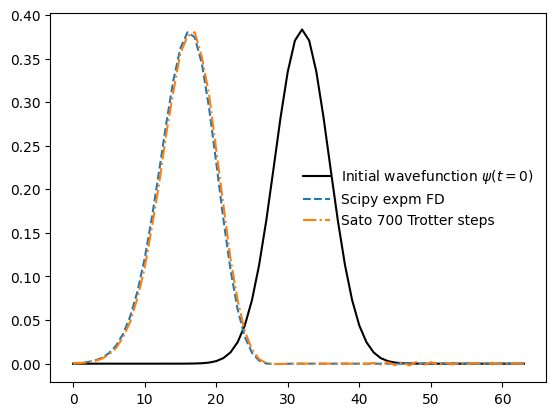

In [5]:
n = 6
tau = -0.25 # 0.5 is moving whole 
#Uqiskit = get_Uqiskit(n,tau)
x = np.arange(0,2**n)
#psi0 = np.heaviside(x-(2**n*0.5),0.5)
psi0 = exp(-0.5*(x-(2**n*0.5))**2/(2**n*0.06)**2)
psi0 /= sqrt( np.sum( np.abs(psi0)**2 ) )
#
plt.plot(x, psi0, 'k-', label=r'Initial wavefunction $\psi(t=0)$' )
plt.plot(x, get_UFD(n, 1/(2**n+1), tau,1)@psi0, '--', label='Scipy expm FD' )
#
tTrotter = 700
Uqiskit_tmp = get_Uqiskit(n,tau/tTrotter * 2**(n-1))
Uqiskit = np.copy(Uqiskit_tmp)
for i in range(tTrotter-1):
    Uqiskit = Uqiskit @ Uqiskit_tmp
plt.plot(x, Uqiskit@psi0, '-.', label='Sato {} Trotter steps'.format(tTrotter) )
#
plt.legend(frameon=False)
plt.show()

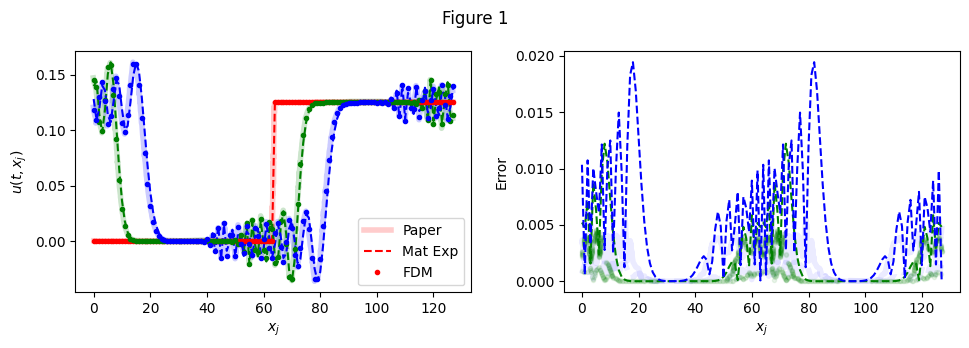

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3.5))
alphaWPD = 0.2
widthWPD = 4
#
f = open('dataWPD/fig1a/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes[0].plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', alpha=alphaWPD, linewidth=widthWPD, color='blue')
#
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes[0].plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', alpha=alphaWPD, linewidth=widthWPD, color='red', label='Paper')
#
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes[0].plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', alpha=alphaWPD, linewidth=widthWPD, color='green')
#
#
f = open('dataWPD/fig1b/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes[1].plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', alpha=alphaWPD*0.4, linewidth=widthWPD, color='blue')
#
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes[1].plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'--', alpha=alphaWPD*0.4, linewidth=widthWPD, color='blue')
#
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes[1].plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', alpha=alphaWPD*0.4, linewidth=widthWPD, color='green')
#
axes[0].set_xlabel(r'$x_j$')
axes[1].set_xlabel(r'$x_j$')
axes[0].set_ylabel(r'$u(t,x_j)$')
axes[1].set_ylabel(r'Error')
#axes[1].set_title(r'nBW')
#axes[0].legend()
#axes[1].legend()
plt.suptitle(r'Figure 1')

# Matrix exponential
n = 7 # #qubits
T = 20.0 # total time
tau = 0.1
tdim = int(T/tau)
ell = 1/(2**n+1) #l := L/(N + 1) page 3/21
#
x = np.arange(0,2**n)
psi0 = np.heaviside(x-(2**n*0.5)+1,0)
psi0 /= sqrt( np.sum( np.abs(psi0)**2 ) )
axes[0].plot(x, psi0, 'r--', label='Mat Exp')
UFD = get_UFD(n,1/(2**n+1),0.08,1)
MatExp1 = UFD@psi0
UFD = get_UFD(n,1/(2**n+1),0.08*2,1)
MatExp2 = UFD@psi0

# Proposed
tdim = 100
Uqiskit_tmp = get_Uqiskit(n,0.08/tdim* 2**(n-1))
Uqiskit = np.copy(Uqiskit_tmp)
for i in range(tdim-1):
    Uqiskit = Uqiskit @ Uqiskit_tmp
#Proposed1 = Uqiskit@psi0
#
Uqiskit_tmp = get_Uqiskit(n,0.08/tdim* 2**(n-1))
Uqiskit = np.copy(Uqiskit_tmp)
for i in range( 2*tdim-1):
    Uqiskit = Uqiskit @ Uqiskit_tmp
#Proposed2 = Uqiskit@psi0

# Finite Differences Method - PDE solver
def solvePDE(n, T, tdim, psi0):
    dt = T/tdim
    psi = psi0 + 0*1j
    dx = 1 #/(2**n)
    Id = np.eye(2**n,dtype=complex)
    H = -1j * (np.roll(Id,-1,axis=0)-np.roll(Id,1,axis=0))/(2*dx)
    for i in range(tdim):
        psi = psi - 1j*dt* H @ psi
    return np.real(psi)
FDM1 = solvePDE(n, T/2, 3000, psi0)
FDM2 = solvePDE(n, T, 3000, psi0)


axes[0].plot(x, MatExp1, 'g--')
axes[0].plot(x, MatExp2, 'b--')
#axes[0].plot(x, Proposed1, 'g-')
#axes[0].plot(x, Proposed2, 'b-')
axes[0].plot(x, psi0, 'r.', label='FDM')
axes[0].plot(x, FDM1, 'g.')
axes[0].plot(x, FDM2, 'b.')

axes[1].plot(x, np.abs(MatExp1-FDM1), 'g--' )
axes[1].plot(x, np.abs(MatExp2-FDM2), 'b--' )

axes[0].legend()
plt.tight_layout()
plt.show()

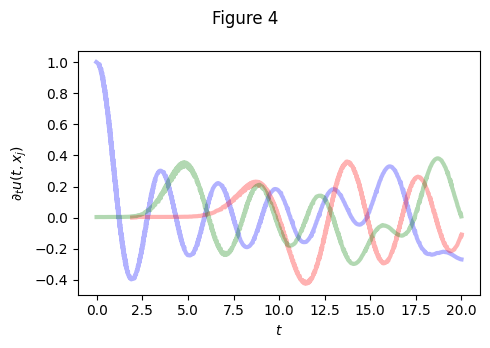

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,3.5))
alphaWPD = 0.3
#
f = open('dataWPD/fig4/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', alpha=alphaWPD, linewidth=3, color='blue')
#
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', alpha=alphaWPD, linewidth=3, color='red')
#
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', alpha=alphaWPD, linewidth=3, color='green')
#
axes.set_xlabel(r'$t$')
axes.set_ylabel(r'$\partial_t u(t,x_j)$')
plt.suptitle(r'Figure 4')
plt.tight_layout()
plt.show()

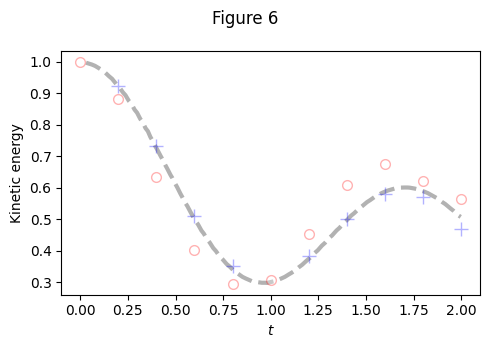

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,3.5))
alphaWPD = 0.3
#
f = open('dataWPD/fig6/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'k--', alpha=alphaWPD, linewidth=3)
#
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'+', alpha=alphaWPD, markersize=10, color='blue')
#
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', alpha=alphaWPD, markersize=7, color='white', markeredgecolor='red')
#
axes.set_xlabel(r'$t$')
axes.set_ylabel(r'Kinetic energy')
plt.suptitle(r'Figure 6')
plt.tight_layout()
plt.show()